#Maksymalizacja prądu płynącego przez układ rezystorowy
[Zadanie YT](https://www.youtube.com/watch?v=buPWuzar384)<br>
5 rezystorów połączonych jest zgodnie z przedstawionym poniżej schematem:
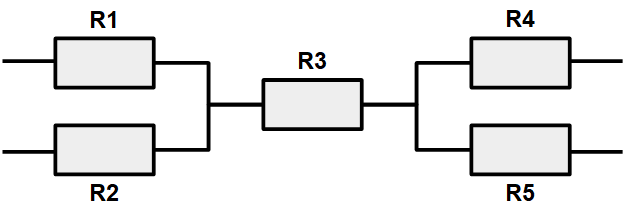<br>
Wartości rezystancji:<br>

| R1 | R2 | R3 | R4 | R5 |
|----|----|----|----|----|
| 8&Omega; | 6&Omega; | 4&Omega; | 10&Omega; | 8&Omega; |

Każdy z rezystorów ma określony limit płynącego prądu:<br>

| R1 | R2 | R3 | R4 | R5 |
|----|----|----|----|----|
| 2A | 3A | 4A | 2A | 2A |

Należy obliczyć maksymalny prąd, który nie spowoduje zniszczenia układu.

In [ ]:
!pip install pulp
!sudo apt-get install coinor-cbc glpk-utils coinor-clp

In [8]:
from pulp import *

In [9]:
# dane
PradUkladu = LpProblem("Prad_ukladu_rezystorow", LpMaximize)
NazwyGalezi = ["R1", "R2", "R3", "R4", "R5"]
Rezystancje = { "R1": 8, "R2" : 6, "R3" : 4, "R4" : 10, "R5" : 8 }
LimitPradow = { "R1": 2, "R2" : 3, "R3" : 4, "R4" : 2,  "R5" : 2 }

PlynacePrady = LpVariable.dicts("Prad", NazwyGalezi, 0)
PradUkladu += PlynacePrady["R3"], "Prad_calego_ukladu"
# limity prądów poszczególnych gałęzi
for iRx in PlynacePrady:
    PradUkladu += PlynacePrady[iRx] <= LimitPradow[iRx]
# prądowe prawo Kirchhoffa
PradUkladu += PlynacePrady["R1"] + PlynacePrady["R2"] == PlynacePrady["R3"]
PradUkladu += PlynacePrady["R4"] + PlynacePrady["R5"] == PlynacePrady["R3"]
# ograniczenie prądów w gałęziach równoległych wynikające z dzielnika rezystancyjnego
PradUkladu += PlynacePrady["R2"] == PlynacePrady["R1"] * Rezystancje["R1"] / Rezystancje["R2"]
PradUkladu += PlynacePrady["R4"] == PlynacePrady["R5"] * Rezystancje["R5"] / Rezystancje["R4"]
# zbędne (redundantne) ograniczenia w gałęziach przeciwległych
#PradUkladu += PlynacePrady["R1"] == PlynacePrady["R2"] * Rezystancje["R2"] / Rezystancje["R1"]
#PradUkladu += PlynacePrady["R5"] == PlynacePrady["R4"] * Rezystancje["R4"] / Rezystancje["R5"]
# rozwiązanie
PradUkladu.solve()
print("Status rozwiazania: ", LpStatus[PradUkladu.status])
print("Układ można obciążyć prądem max. {:.2f} A".format(PradUkladu.objective.value()))
for var in PradUkladu.variables():
    print("{}: {:.2f} A".format(var.name, var.value()))

Status rozwiazania:  Optimal
Układ można obciążyć prądem max. 3.60 A
Prad_R1: 1.54 A
Prad_R2: 2.06 A
Prad_R3: 3.60 A
Prad_R4: 1.60 A
Prad_R5: 2.00 A


# Minimalizacja utraconej mocy
[Zadanie YT](https://www.youtube.com/watch?v=yZuVfekIXJ0)<br>
W przedstawionym poniżej mostku należy dobrać wartości rezystancji tak, aby zminimalizować straty mocy.<br>
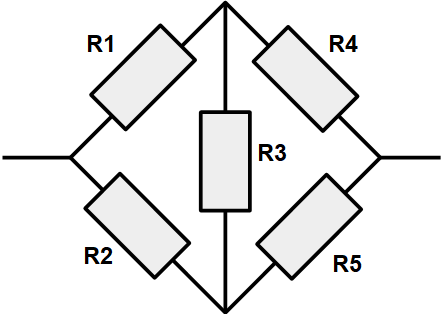<br>
W danej gałęzi <i>i</i> przy znanym napięciu <i>u<sub>i</sub></i> ma popłynąć zadany prąd <i>i<sub>i</sub></i> z określoną dokładnością:
<i>&Delta;i<sub>i</sub> + i<sub>i</sub> &ge; I<sub>i</sub> &ge; &Delta;i<sub>i</sub> + i<sub>i</sub></i><br>

| i | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|
| <i>u<sub>i</sub></i> | 6V | 10V | 4V | 7V | 3V |
| <i>i<sub>i</sub></i> | 4mA | 2mA | 2mA | 2mA | 4mA |
| <i>&Delta;i<sub>i</sub> | 1mA | 1mA | 1mA | 1mA | 1mA |


In [10]:
# dane
galezie = [ "R1", "R2", "R3", "R4", "R5" ]
# [V]
napiecie =  { "R1" : 6, "R2" : 10, "R3" : 4, "R4" : 7, "R5" : 3 }
# [mA]
prad =      { "R1" : 4, "R2" : 2,  "R3" : 2, "R4" : 2, "R5" : 4 }
# [mA]
bladPradu = { "R1" : 1, "R2" : 1,  "R3" : 1, "R4" : 1, "R5" : 1 }

# minimalizacja mocy poprzez maksymalizację jej odwrotności (dzielenie niedozwolone)
# [mW]
problemMocy = LpProblem("Minimalizacja_mocy_rozproszenia", LpMinimize)
# konduktywność została wybrana zamiast rezystancji ze względu na konieczność eliminacji dzielenia
# [mS]
konduktancja = LpVariable.dicts("Konduktancja", galezie, 0, None, "Continous")
# moc rozproszenia ze wzoru U^2 / R przy stałym napięciu, czyli U^2 * Y w wersji liniowej
problemMocy += lpSum(napiecie[galaz] * napiecie[galaz] * konduktancja[galaz] for galaz in galezie), "Moc_rozproszenia"
# ograniczenie pradów z zadaną dokładnością
for galaz in galezie:
    problemMocy += napiecie[galaz] * konduktancja[galaz] >= prad[galaz] - bladPradu[galaz]
    problemMocy += napiecie[galaz] * konduktancja[galaz] <= prad[galaz] + bladPradu[galaz]
# prądowe prawo Kirchhoffa z mnożeniem
problemMocy += napiecie["R1"] * konduktancja["R1"] == napiecie["R3"] * konduktancja["R3"] + napiecie["R4"] * konduktancja["R4"]
problemMocy += napiecie["R5"] * konduktancja["R5"] == napiecie["R3"] * konduktancja["R3"] + napiecie["R2"] * konduktancja["R2"]
# napięciowe prawo Kirchhoffa spełnione z złożeń
# rozwiązanie
problemMocy.solve()
print("Status rozwiązania: {}".format(LpStatus[problemMocy.status]))
print("Moc strat wynosi {:.1f} mW.".format(problemMocy.objective.value()))
print("Wybrane rezystory: ")
for v in problemMocy.variables():
    print("Rezystor {} = {:.3} kOhm".format(v.name[v.name.index("_") + 1:], 1.0 / v.value()))



Status rozwiązania: Optimal
Moc strat wynosi 52.0 mW.
Wybrane rezystory: 
Rezystor R1 = 2.0 kOhm
Rezystor R2 = 10.0 kOhm
Rezystor R3 = 2.0 kOhm
Rezystor R4 = 7.0 kOhm
Rezystor R5 = 1.0 kOhm


#Podsumowanie
W zadaniach liniowych zmienne decyzyjne nie mogą występować w dzieleniach. Należy więc przyjąć odpowiednie zmienne. Jadnym z rozwiązań jest wykonywanie obliczeń na ich odwrotnościach. W podanym przykładzie zastosowane zostało właśnie to podejście - rezystancja została zastąpiona swoją odwrotnością, czyli konduktancją.<br>
Alternatywnie jako zmienne mogłyby zostać przyjęte prądy w gałęziach, a wynik (rezystancja) obliczany byłby zewnętrznie (jako iloraz napięcia i prądu w gałęzi).<br>
Poza dzieleniem przez zmienną niedozwolone jest również wymnażanie dwóch zmiennych, więc dodanie ograniczenia w postaci: <br>

```
zmiennaProsta * zmiennaOdwrócona == 1
```
 skutkuje błędem (wówczas równanie stałoby się kwadratowe). Należy zatem zastosować jedno ze wspomnianych wcześniej rozwiązań. 